In [1]:
import xgboost as xgb ## XGBoost 불러오기
from xgboost import plot_importance ## Feature Importance를 불러오기 위함
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

데이터 불러와서 합치기

In [6]:
data1 = pd.read_csv("C:\\Users\\asus\\BigContest\\files\\data_preprocessing\\1_food_waste_preprocessing.csv")
data2_1 = pd.read_csv("C:\\Users\\asus\\BigContest\\files\\data_preprocessing\\2_1_korean_preprocessing.csv")
data2_2 = pd.read_csv("C:\\Users\\asus\\BigContest\\files\\data_preprocessing\\2_2_long_term_frgn_preprocessing.csv")
data2_3 = pd.read_csv("C:\\Users\\asus\\BigContest\\files\\data_preprocessing\\2_3_short_term_frgn_3_resident_pop_preprocessing.csv")
data4 = pd.read_csv("C:\\Users\\asus\\BigContest\\files\\data_preprocessing\\4_card_spending_preprocessing.csv")

In [21]:
data_merge = pd.merge(data2_1, data2_2, on=['base_date', 'emd_cd'])
data_merge = pd.merge(data_merge, data2_3, on=['base_date', 'emd_cd'])
data_merge = pd.merge(data_merge, data4, on=['base_date', 'emd_cd'])
data_merge = pd.merge(data_merge, data1, on=['base_date', 'emd_cd'])
data_merge

,base_date,emd_cd,pop_cnt_x,pop_cnt_y,visit_pop_cnt,total_pop,use_cnt_mean,emd_amt_mean,em_cnt,em_g
0,2019-11-30,50110250,7.321788e+06,469689.3527,129161.4006,25149,267.380645,9586590.265,620,2279550
1,2019-12-31,50110250,6.915173e+06,482920.2385,122124.6609,25080,266.814465,9621756.255,8178,31493650
2,2020-01-31,50110250,7.476137e+06,587299.9640,112758.3034,25076,257.604430,9648302.136,13042,49632850
3,2020-02-29,50110250,5.561978e+06,559439.3959,60252.7989,25021,249.621160,8760701.457,12264,46197050
4,2020-03-31,50110250,6.094369e+06,714445.0812,29661.4429,24942,261.877023,8979547.945,14316,52561750
...,...,...,...,...,...,...,...,...,...,...
1629,2021-02-28,50130620,4.321265e+06,109325.4866,280.6159,4173,65.216000,2463788.712,4563,15566250
1630,2021-03-31,50130620,4.744309e+06,118258.8891,1475.8404,4178,67.700000,2572585.700,4920,17300600
1631,2021-04-30,50130620,5.236706e+06,129227.7480,1283.0997,4161,68.642336,2473174.901,5256,17646850
1632,2021-05-31,50130620,5.805413e+06,144213.2650,1212.2652,4178,69.333333,2864493.949,6346,19494750


In [28]:
data_merge.columns = ['base_date', 'emd_cd', 'korean', 'long_term_frgn', 'short_term_frgn', 'resident', 'card_cnt', 'card_amt', 'waste_cnt', 'waste_amt']
data_merge

,base_date,emd_cd,korean,long_term_frgn,short_term_frgn,resident,card_cnt,card_amt,waste_cnt,waste_amt
0,2019-11-30,50110250,7.321788e+06,469689.3527,129161.4006,25149,267.380645,9586590.265,620,2279550
1,2019-12-31,50110250,6.915173e+06,482920.2385,122124.6609,25080,266.814465,9621756.255,8178,31493650
2,2020-01-31,50110250,7.476137e+06,587299.9640,112758.3034,25076,257.604430,9648302.136,13042,49632850
3,2020-02-29,50110250,5.561978e+06,559439.3959,60252.7989,25021,249.621160,8760701.457,12264,46197050
4,2020-03-31,50110250,6.094369e+06,714445.0812,29661.4429,24942,261.877023,8979547.945,14316,52561750
...,...,...,...,...,...,...,...,...,...,...
1629,2021-02-28,50130620,4.321265e+06,109325.4866,280.6159,4173,65.216000,2463788.712,4563,15566250
1630,2021-03-31,50130620,4.744309e+06,118258.8891,1475.8404,4178,67.700000,2572585.700,4920,17300600
1631,2021-04-30,50130620,5.236706e+06,129227.7480,1283.0997,4161,68.642336,2473174.901,5256,17646850
1632,2021-05-31,50130620,5.805413e+06,144213.2650,1212.2652,4178,69.333333,2864493.949,6346,19494750


In [57]:
data_merge.to_csv("C:\\Users\\asus\\BigContest\\files\\data_preprocessing\\ver_1_merge_data.csv", index_label=False)

xgboost 모델링

In [37]:
X_features = data_merge.loc[:, ['korean', 'long_term_frgn', 'short_term_frgn', 'resident', 'card_cnt', 'card_amt', 'waste_cnt']]
y_label = data_merge.loc[:, 'waste_amt']

In [38]:
# 전체 데이터셋을 학습용 80%, 테스트용 20%로 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

(1307, 7) (327, 7)


In [39]:
# 넘파이 형태의 학습 데이터 세트와 테스트 데이터를 DMatrix로 변환하는 예제
dtrain = xgb.DMatrix(data=X_train, label = y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [51]:
# max_depth = 3, 학습률은 0.1, 목적함수(objective)는 reg:linear(회귀)
# 오류함수의 평가성능지표는 rmse
# 부스팅 반복횟수는 400
# 조기중단을 위한 최소 반복횟수는 100

params = {'max_depth' : 3,
         'eta' : 0.1, 
         'objective' : 'reg:linear',
         'eval_metric' : 'rmse',
         'early_stoppings' : 100 }
num_rounds = 1000

In [52]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval' 로 명기
wlist = [(dtrain, 'train'), (dtest,'eval')]
# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)

[18:43:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[18:43:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:80015096.00000	eval-rmse:75677592.00000
[1]	train-rmse:72313720.00000	eval-rmse:68352704.00000
[2]	train-rmse:65388064.00000	eval-rmse:61823020.00000
[3]	train-rmse:59144432.00000	eval-rmse:55798372.00000
[4]	train-rmse:53527564.00000	eval-rmse:50479740.00000
[5]	train-rmse:48488592.00000	eval-rmse:45694892.00000
[6]	train-rmse:43939936.00000	eval-rmse:41329336.00000
[7]	train-rmse:39861560.00000	eval-rmse:375

[140]	train-rmse:4586924.50000	eval-rmse:6012331.50000
[141]	train-rmse:4570284.00000	eval-rmse:6000982.50000
[142]	train-rmse:4561084.50000	eval-rmse:6003039.50000
[143]	train-rmse:4540163.00000	eval-rmse:6002135.50000
[144]	train-rmse:4523944.50000	eval-rmse:5987176.00000
[145]	train-rmse:4509837.00000	eval-rmse:5976000.50000
[146]	train-rmse:4506888.00000	eval-rmse:5979999.00000
[147]	train-rmse:4499094.00000	eval-rmse:5972748.50000
[148]	train-rmse:4488001.00000	eval-rmse:5970246.00000
[149]	train-rmse:4480265.00000	eval-rmse:5968887.00000
[150]	train-rmse:4464112.00000	eval-rmse:5959225.50000
[151]	train-rmse:4449249.00000	eval-rmse:5953170.50000
[152]	train-rmse:4443824.00000	eval-rmse:5945823.00000
[153]	train-rmse:4429781.00000	eval-rmse:5937982.00000
[154]	train-rmse:4407423.50000	eval-rmse:5924293.50000
[155]	train-rmse:4390308.50000	eval-rmse:5909887.50000
[156]	train-rmse:4379383.00000	eval-rmse:5909576.50000
[157]	train-rmse:4365240.50000	eval-rmse:5908962.50000
[158]	trai

[288]	train-rmse:3337833.00000	eval-rmse:5609349.00000
[289]	train-rmse:3334070.00000	eval-rmse:5609100.50000
[290]	train-rmse:3329734.25000	eval-rmse:5607819.50000
[291]	train-rmse:3322247.00000	eval-rmse:5604919.00000
[292]	train-rmse:3318430.75000	eval-rmse:5601760.50000
[293]	train-rmse:3303574.25000	eval-rmse:5597752.50000
[294]	train-rmse:3294945.00000	eval-rmse:5592004.00000
[295]	train-rmse:3283669.50000	eval-rmse:5588002.00000
[296]	train-rmse:3280644.50000	eval-rmse:5586671.50000
[297]	train-rmse:3272617.25000	eval-rmse:5586988.50000
[298]	train-rmse:3266480.75000	eval-rmse:5586658.50000
[299]	train-rmse:3260926.75000	eval-rmse:5588003.00000
[300]	train-rmse:3254852.75000	eval-rmse:5589578.00000
[301]	train-rmse:3250727.50000	eval-rmse:5585600.50000
[302]	train-rmse:3246200.25000	eval-rmse:5588237.00000
[303]	train-rmse:3244934.50000	eval-rmse:5588314.00000
[304]	train-rmse:3238753.75000	eval-rmse:5589720.50000
[305]	train-rmse:3234871.50000	eval-rmse:5592683.50000
[306]	trai

[437]	train-rmse:2643236.75000	eval-rmse:5460840.50000
[438]	train-rmse:2639147.75000	eval-rmse:5458293.00000
[439]	train-rmse:2635449.50000	eval-rmse:5461419.00000
[440]	train-rmse:2632534.25000	eval-rmse:5461982.50000
[441]	train-rmse:2630025.00000	eval-rmse:5460915.50000
[442]	train-rmse:2628578.25000	eval-rmse:5462119.50000
[443]	train-rmse:2624963.50000	eval-rmse:5461820.00000
[444]	train-rmse:2618093.75000	eval-rmse:5458135.00000
[445]	train-rmse:2615503.75000	eval-rmse:5456836.00000
[446]	train-rmse:2612847.25000	eval-rmse:5456358.50000
[447]	train-rmse:2611757.00000	eval-rmse:5455121.00000
[448]	train-rmse:2606826.50000	eval-rmse:5453609.00000
[449]	train-rmse:2604446.50000	eval-rmse:5456814.00000
[450]	train-rmse:2603985.00000	eval-rmse:5456335.50000
[451]	train-rmse:2603005.25000	eval-rmse:5455055.50000
[452]	train-rmse:2598475.50000	eval-rmse:5453642.00000
[453]	train-rmse:2591884.50000	eval-rmse:5455533.00000
[454]	train-rmse:2586241.75000	eval-rmse:5457339.00000
[455]	trai

[586]	train-rmse:2172992.00000	eval-rmse:5447767.00000
[587]	train-rmse:2169830.25000	eval-rmse:5444361.00000
[588]	train-rmse:2168758.25000	eval-rmse:5443559.50000
[589]	train-rmse:2166656.25000	eval-rmse:5442569.50000
[590]	train-rmse:2164011.50000	eval-rmse:5443066.00000
[591]	train-rmse:2159909.50000	eval-rmse:5443806.50000
[592]	train-rmse:2157239.25000	eval-rmse:5443892.00000
[593]	train-rmse:2156019.50000	eval-rmse:5443000.50000
[594]	train-rmse:2155642.50000	eval-rmse:5443194.00000
[595]	train-rmse:2154857.50000	eval-rmse:5443646.00000
[596]	train-rmse:2149802.25000	eval-rmse:5443275.00000
[597]	train-rmse:2148491.25000	eval-rmse:5443311.00000
[598]	train-rmse:2147266.25000	eval-rmse:5442618.50000
[599]	train-rmse:2145145.00000	eval-rmse:5443375.50000
[600]	train-rmse:2144014.00000	eval-rmse:5443714.00000
[601]	train-rmse:2143583.25000	eval-rmse:5441892.00000
[602]	train-rmse:2140256.25000	eval-rmse:5441212.00000
[603]	train-rmse:2135915.50000	eval-rmse:5445857.00000
[604]	trai

[735]	train-rmse:1790698.62500	eval-rmse:5411881.50000
[736]	train-rmse:1788828.00000	eval-rmse:5411401.50000
[737]	train-rmse:1785782.50000	eval-rmse:5413815.50000
[738]	train-rmse:1782707.12500	eval-rmse:5413416.50000
[739]	train-rmse:1780024.37500	eval-rmse:5412206.50000
[740]	train-rmse:1777650.25000	eval-rmse:5413532.50000
[741]	train-rmse:1774516.25000	eval-rmse:5413272.00000
[742]	train-rmse:1768889.87500	eval-rmse:5412030.00000
[743]	train-rmse:1766060.37500	eval-rmse:5412756.00000
[744]	train-rmse:1761314.25000	eval-rmse:5411680.00000
[745]	train-rmse:1759200.00000	eval-rmse:5411269.00000
[746]	train-rmse:1757853.50000	eval-rmse:5411579.00000
[747]	train-rmse:1754835.75000	eval-rmse:5410375.50000
[748]	train-rmse:1752249.62500	eval-rmse:5409489.00000
[749]	train-rmse:1750598.25000	eval-rmse:5408955.00000
[750]	train-rmse:1748901.12500	eval-rmse:5408660.50000
[751]	train-rmse:1746815.37500	eval-rmse:5408414.00000
[752]	train-rmse:1742444.00000	eval-rmse:5409328.00000
[753]	trai

[884]	train-rmse:1494298.87500	eval-rmse:5418864.00000
[885]	train-rmse:1492580.00000	eval-rmse:5419366.00000
[886]	train-rmse:1492208.12500	eval-rmse:5419594.50000
[887]	train-rmse:1491752.62500	eval-rmse:5420759.50000
[888]	train-rmse:1489855.25000	eval-rmse:5420723.50000
[889]	train-rmse:1488190.37500	eval-rmse:5422417.00000
[890]	train-rmse:1486016.62500	eval-rmse:5421242.50000
[891]	train-rmse:1482582.12500	eval-rmse:5420581.50000
[892]	train-rmse:1481746.87500	eval-rmse:5420097.50000
[893]	train-rmse:1479675.25000	eval-rmse:5419741.50000
[894]	train-rmse:1478695.00000	eval-rmse:5419557.00000
[895]	train-rmse:1475741.62500	eval-rmse:5419025.00000
[896]	train-rmse:1475003.37500	eval-rmse:5418619.50000
[897]	train-rmse:1474351.75000	eval-rmse:5419056.50000
[898]	train-rmse:1471222.50000	eval-rmse:5418902.00000
[899]	train-rmse:1469803.00000	eval-rmse:5421425.50000
[900]	train-rmse:1469437.50000	eval-rmse:5423106.00000
[901]	train-rmse:1467753.12500	eval-rmse:5421922.00000
[902]	trai

In [46]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시: ', preds[:10])

predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[9.4995400e+06 1.8893941e+08 2.5850392e+07 2.2333696e+08 4.4402028e+07
 3.8302156e+07 7.0544736e+07 3.7387332e+07 1.0382598e+08 9.7040432e+07]
예측값 10개만 표시:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [54]:
# 혼동행렬, 정확도, 정밀도, 재현율, F1, AUC 불러오기
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

In [55]:
get_clf_eval(y_test, preds)

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

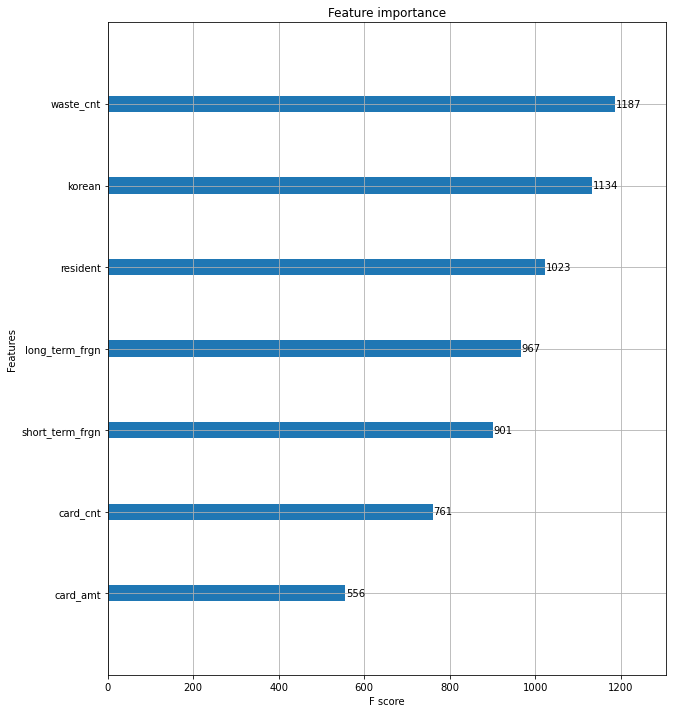

In [53]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)